Examination of DDPM and CEM on Bayesian Inversion problems.
===========================================================




# Table of Contents







## Problem Statement



This is an investigation into the use of diffusion models to solve the problem discussed in (Adler, Jonas and Öktem, Ozan, 2018). Specifically, we use DDPM and CEM to model the problems. We want to investigate if DDPM and CEM will perform better than the reference method/model ((Adler, Jonas and Öktem, Ozan, 2018)) to denoise ultra low dose CT scans, and produce higher quality CT scans similar to the normal dose images.

In a CT scan of a 3D subject, multiple 2D projections are generated for each angle of projection. Projections are created by the forward projection algorithm,and measures the attenutation (reduction in intensity) of the x-ray beam (cast no the subject towards the deector). A sinogram consist of mutiple projections stacked together. We can then reconstruct a 3D image of the subject of interest through a back projection algorithm such as filtered back projection (FBP). Filtered back projection is the industry standard to reconstruct images from sinograms because it is fast and robust. FBP applies a image de-blur filter (sharpen) to the projection (sinogram) and then back project the resulting projection to a 3D image. In back projection, we map the data in detector space to image space.

In (Adler, Jonas and Öktem, Ozan, 2018), we train two neural networks (GAN) to assist in the analysis of ultra low dose CT scans. An ultra low dose CT scan is simulated from a normal dose CT scan image. Projections are sampled from the normal dose image and Poisson noise is added to the projections. The ultra low dose CT image is then reconstructed using filtered back projection (FBP). The first neural network (deep posterior sampling) produces (high quality) sample images from the ultra low dose images. The second neural network (deep direct estimation) returns the mean and variance (of what the normal dose should be) given an ultra lose dose image.

(Moen, Taylor R. and Chen, Baiyu and Holmes III, David R. and Duan, Xinhui and Yu, Zhicong and Yu, Lifeng and Leng, Shuai and Fletcher, Joel G. and McCollough, Cynthia H., 2021) provides an overview of the data provided for the grand challenge. In particular, the low dose projection (DICOM-CT-PD) are simulated from the normal dose projections.



### Filtered Back Projection (FBP)



Found a site on filtered back projection [https://howradiologyworks.com/filtered-backprojection-fbp-illustrated-guide-for-radiologic-technologists/#:~:text=Back%20projection%20is%20the%20process,Filtered%20Backprojection%20and%20Iterative%20Reconstruction](https://howradiologyworks.com/filtered-backprojection-fbp-illustrated-guide-for-radiologic-technologists/#:~:text=Back%20projection%20is%20the%20process,Filtered%20Backprojection%20and%20Iterative%20Reconstruction). A traditional x-ray scan gives us a 2d image of a subject of interest from a view (usually in front of the patient for a chest scan). One 2d image does not provide us a very good understanding of the subject. A forward projection algorithm instead takes multiple 2d images of a the subject from multiple and different angles/views. The end results are <u>sinograms</u>. Each line/row in a sinogram corresponds to 2d image taken of the subject at particular view. A sinogram is so named because each point in the subject corresponds traces a sinusoid curve.

Given knowledge of how a forward projection works, we can reverse the process (which we call back projection) to reconstruct an image of the subject. Because the back projection (BP) is performed one view at a time, the resulting reconstructed image is a blurred image ([https://www.youtube.com/watch?v=YvYIkbiRMy0](https://www.youtube.com/watch?v=YvYIkbiRMy0)). To remedy this problem, we can apply a sharpening step (or image deblurring). This image deblurring can be applied in three different manner:

1.  BP projection to image then apply image de-blur
2.  De-blur projection then BP to image
3.  De-blur projection, BP to image, then finally de-blur again

The second option (called Filtered Back Projection or FBP) is the most common as it is fast and robust. Back projection is the process of mapping the data from the detector space to the image space, while forward projection is the process of mapping the data in the image space to the detector space.



## Data



We use data from 2016 Low Dose CT Grand Challenge ([https://www.aapm.org/grandchallenge/lowdosect/#testDatasets](https://www.aapm.org/grandchallenge/lowdosect/#testDatasets)). Training data is downloaded from box at [https://aapm.app.box.com/s/eaw4jddb53keg1bptavvvd1sf4x3pe9h](https://aapm.app.box.com/s/eaw4jddb53keg1bptavvvd1sf4x3pe9h). ([https://www.imagewisely.org/Imaging-Modalities/Computed-Tomography/Image-Reconstruction-Techniques](https://www.imagewisely.org/Imaging-Modalities/Computed-Tomography/Image-Reconstruction-Techniques)) The data contains images reconstructed using two reconstruction kernels B30 and D45. Reconstruction kernels (also called “filter” or “algorithm”) affects the image quality. There is a tradeoff between spatial resolution and noise. A smoother kernel generates images with lower noise but with reduced spatial resolution. A sharper kernel generates images with higher spatial resolution, but increases the image noise. Spatial resolution in CT is the ability to differentiate objects of different density. A high spatial resolution is important to distinguish objects that are close to one another.

Patient<sub>Data</sub> directory contains the reconstructed images and projections (in DICOM-CT-PD format) of the CT scans.
Ancillary<sub>Information</sub> contains detailed documentation on the file format DICOM-CT-PD (vendor neutral DICOM format), and lesion information.



In [1]:
import mnist

normalized_images = mnist.get_training_data()

2024-03-06 20:33:52.902441: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.4.99). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.

We examine some full dose samples from the training images.



In [1]:
from skimage.transform import iradon
from pydicom import dcmread
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

path='/Users/huiyuanchua/Documents/Mayo_Grand_Challenge/Patient_Data'

ima_path=f'{path}/Training_Image_Data/3mm B30'
ima_fd_path=f'{ima_path}/full_3mm/L067/full_3mm'

pathlist = Path(ima_fd_path).rglob('*.IMA')
ima_files = [ima for ima in pathlist]

n = 3
images=[]
ima_batch = np.random.choice(ima_files, size=n**2, replace=False)
fig, axs = plt.subplots(n, n, figsize=(3 *n, 3 * n), sharex=True, sharey=True)
_ = fig.tight_layout()
for i, ima_file in enumerate(ima_batch):
    ima = dcmread(ima_file)
    image = ima.pixel_array
    images.append(image)
    ax = axs[i // n][i % n]
    ax.imshow(image, cmap=plt.cm.Greys_r,)
plt.show()

We apply forward projection on the batch to obtain their respective sinograms (Radon transform).



/Users/huiyuanchua/miniconda3/envs/venv310/lib/python3.10/site-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '

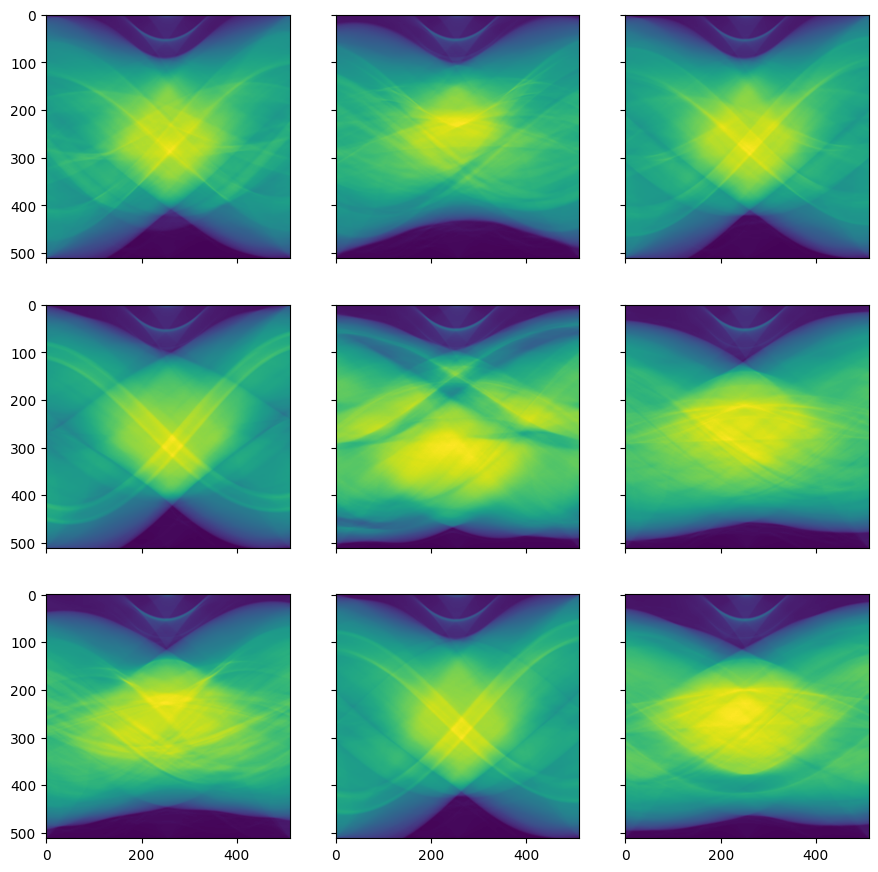

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

sinograms = []
fig, axs = plt.subplots(n, n, figsize=(3 *n, 3 * n), sharex=True, sharey=True)
_ = fig.tight_layout()
for i, image in enumerate(images):
    ax = axs[i // n][i % n]

    theta = np.linspace(0., 180., max(image.shape), endpoint=False)
    sinogram = radon(image, theta=theta)
    sinograms.append(sinogram)
    dx, dy = 0.5 * 180.0 / max(image.shape), 0.5 / sinogram.shape[0]
    ax.imshow(sinogram, cmap=plt.cm.Greys_r,
               extent=(-dx, 180.0 + dx, -dy, sinogram.shape[0] + dy),
               aspect='auto')

    ax.imshow(sinogram)
plt.show()

We now apply filtered back projection to reconstruct the original image using the filter "ramp".



FBP rms reconstruction error: 803

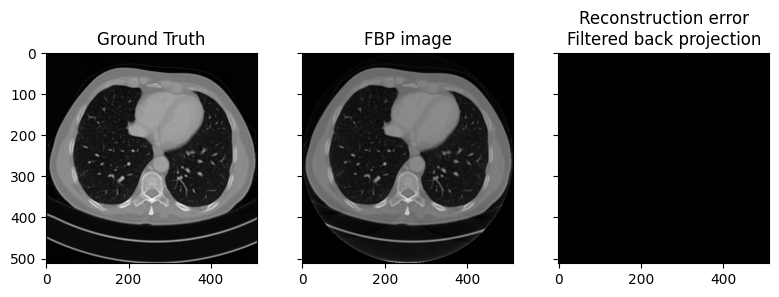

In [1]:
from skimage.transform import iradon
from pydicom import dcmread
import matplotlib.pyplot as plt

sinogram = sinograms[4]
image = images[4]
reconstruction_fbp = iradon(sinogram, theta=theta, filter_name='ramp')
error = reconstruction_fbp - images[i]
print(f'FBP rms reconstruction error: {np.sqrt(np.mean(error**2)):.3g}')

imkwargs = dict(vmin=-0.2, vmax=0.2)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 4.5), sharex=True, sharey=True)
_ = fig.tight_layout()
ax1.set_title("Ground Truth")
ax1.imshow(image, cmap=plt.cm.Greys_r)
ax2.set_title("FBP image")
ax2.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
ax3.set_title("Reconstruction error\nFiltered back projection")
ax3.imshow(reconstruction_fbp - image, cmap=plt.cm.Greys_r, **imkwargs)
plt.show()

Next, we explore if it's possible to reconstruct images from Mayo's full dose projections, and how it compares with the provided images.



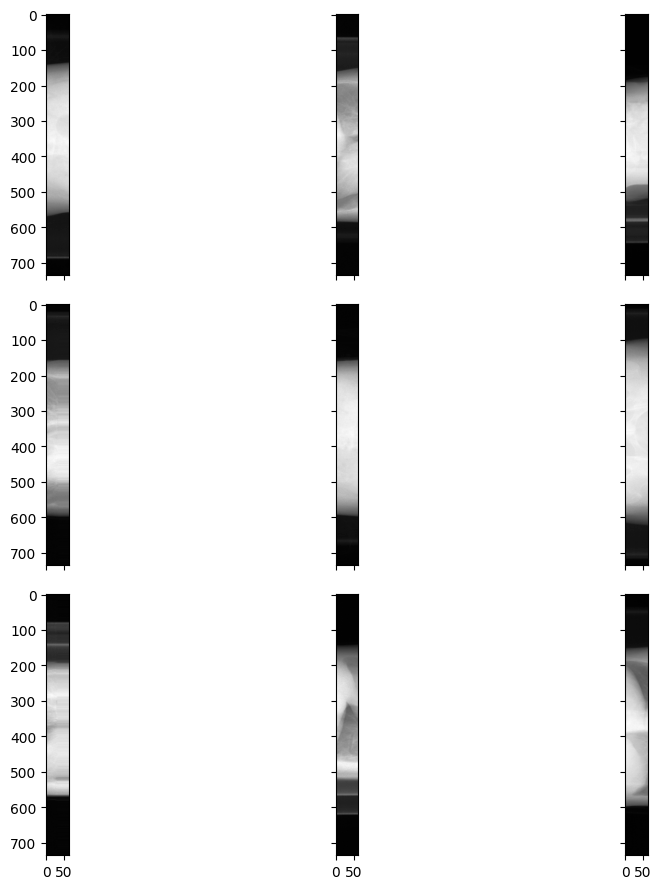

In [1]:
from pydicom import dcmread
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

path='/Users/huiyuanchua/Documents/Mayo_Grand_Challenge/Patient_Data'

dcm_path=f'{path}/Training_Projection_Data/L067'
dcm_fd_path=f'{dcm_path}/DICOM-CT-PD_FD'

pathlist = Path(dcm_fd_path).rglob('*.dcm')
dcm_files = [dcm_file for dcm_file in pathlist]

n = 3
sinograms=[]
sinogram_batch = np.random.choice(dcm_files, size=n**2, replace=False)
fig, axs = plt.subplots(n, n, figsize=(3 *n, 3 * n), sharex=True, sharey=True)
_ = fig.tight_layout()
for i, sinogram_file in enumerate(sinogram_batch):
    dcm = dcmread(sinogram_file)
    sinogram = dcm.pixel_array
    sinograms.append(sinogram)
    ax = axs[i // n][i % n]
    ax.imshow(sinogram, cmap=plt.cm.Greys_r,)
plt.show()

## DDPM



DDPM specific parameters.



In [1]:
import os

SEED=42
MIN_BETA, MAX_BETA = 1e-4, 0.02
K = 1000
N_EPOCH = 30
BATCH_SIZE = 10
PROJECT_DIR=os.path.abspath('.')

### Training



Training is performed via a python script [train_ddpm.py](train_ddpm.py). We examine the average epoch loss with the following code:



#+attr_org: :width 484

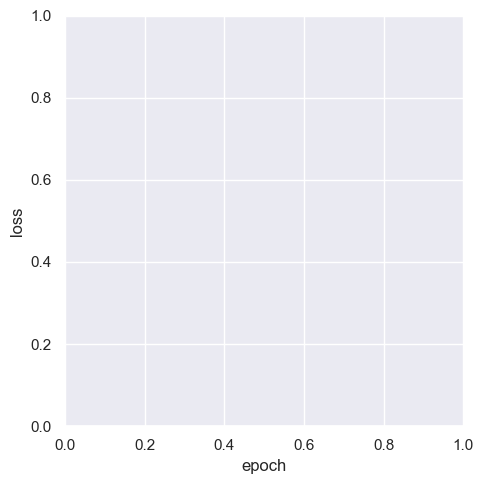

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import utils

ddpm_loss_log = utils.load_loss_log(f'{PROJECT_DIR}/ddpm_loss_log.npy')

# plot losses
df = pd.DataFrame([(int(x), float(y)) for x, _, y in ddpm_loss_log], columns=['epoch', 'loss'])
sns.relplot(df, x='epoch', y='loss', kind='line')

_ = plt.tight_layout()
_ = plt.show()

### Sampling



We sample images from the trained DDPM model.



2024-03-07 08:56:45.170093: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.4.99). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
using parameters from epoch 8 with loss 0.02443
100% 1000/1000 [14:06<00:00,  1.18it/s]
#+attr_org: :width 529

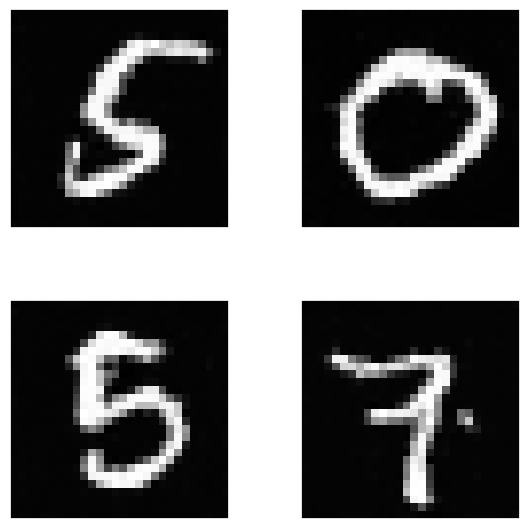

In [1]:
import matplotlib.pyplot as plt
import optax
from jax import random
import jax.numpy as jnp
from tqdm import tqdm

import utils
from unet import Unet

def sample(state, n, betas, key):
  # random white noise X_T
  key, subkey = random.split(key)
  x_k = random.normal(subkey, shape=(n, 28, 28, 1))

  #dts = np.array([ts[i] - ts[i-1] for i in range(1, steps+1)])
  #betas = 1- np.exp(-dts)
  alphas = 1 - betas
  alpha_bars = jnp.cumprod(alphas)
  #alpha_bars = jnp.array([alphas[:i+1].prod() for i in range(len(alphas))]) # workaround for metal problem with jnp.cumprod

  # sample in reverse from T=10 to 0.0 in evenly distributed steps
  #for i in tqdm(range(steps)[::-1]):
  for k in tqdm(range(len(betas))[::-1]):
    alpha = alphas[k]
    beta = betas[k]
    alpha_bar_k = alpha_bars[k]

    key, subkey = random.split(key)
    z = jnp.where(k > 1, random.normal(subkey, shape=x_k.shape), jnp.zeros_like(x_k))
    sigma_k = jnp.sqrt(beta) # option 1; see DDPM 3.2
    #sigma_k = jnp.sqrt((1-alpha_bars[k-1])/(1 - alpha_bar_k) * beta) # option 2; see DDPM 3.2

    x_k = 1/jnp.sqrt(alpha) * (x_k - beta/jnp.sqrt(1 - alpha_bar_k) * state.apply_fn(state.params, x_k, k * jnp.ones((x_k.shape[0], )))) + sigma_k * z

    x_k = jnp.clip(x_k, -1., 1.) # should we clip ...
    #x_t = normalize_to_neg_one_to_one(x_t) # or scale?

  return x_k

key = random.PRNGKey(SEED)

# use the best params
file_path, epoch, step, loss = utils.find_latest_pytree(f'{PROJECT_DIR}/ddpm_params_*.npy')
ddpm_state = utils.create_training_state(params_file=f'{PROJECT_DIR}/ddpm_params_{epoch}_{step}_{loss}.npy')
print(f'using parameters from epoch {epoch} with loss {loss}')

betas = jnp.linspace(MIN_BETA, MAX_BETA, K)

# generate x_0 from noise
key, subkey = random.split(key)
x_0_tilde = sample(ddpm_state, 4, betas, subkey)

# plot the data
utils.show_img_grid(utils.unnormalize_image(x_0_tilde))

## CEM



In [1]:
import os

SEED=42
T=10.
K=1000
BATCH_SIZE = 1000
PROJECT_DIR=os.path.abspath('.')

### Training



Training is performed via a python script [train_cem.py](train_cem.py). We examine the average epoch loss with the following code:



#+attr_org: :width 484

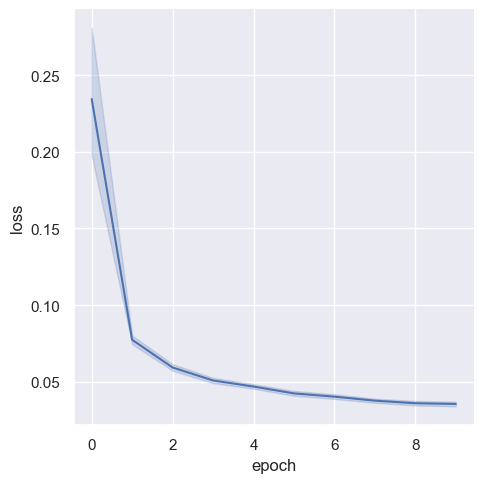

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import utils

cem_loss_log = utils.load_loss_log(f'{PROJECT_DIR}/cem_loss_log.npy')

# plot losses
df = pd.DataFrame([(int(x), float(y)) for x, _, y in cem_loss_log], columns=['epoch', 'loss'])
sns.relplot(df, x='epoch', y='loss', kind='line')

_ = plt.tight_layout()
_ = plt.show()

### Sampling



We sample images from the trained CEM model.



using parameters from epoch 9 with loss 0.03557
100% 1002/1002 [09:41<00:00,  1.72it/s]
:

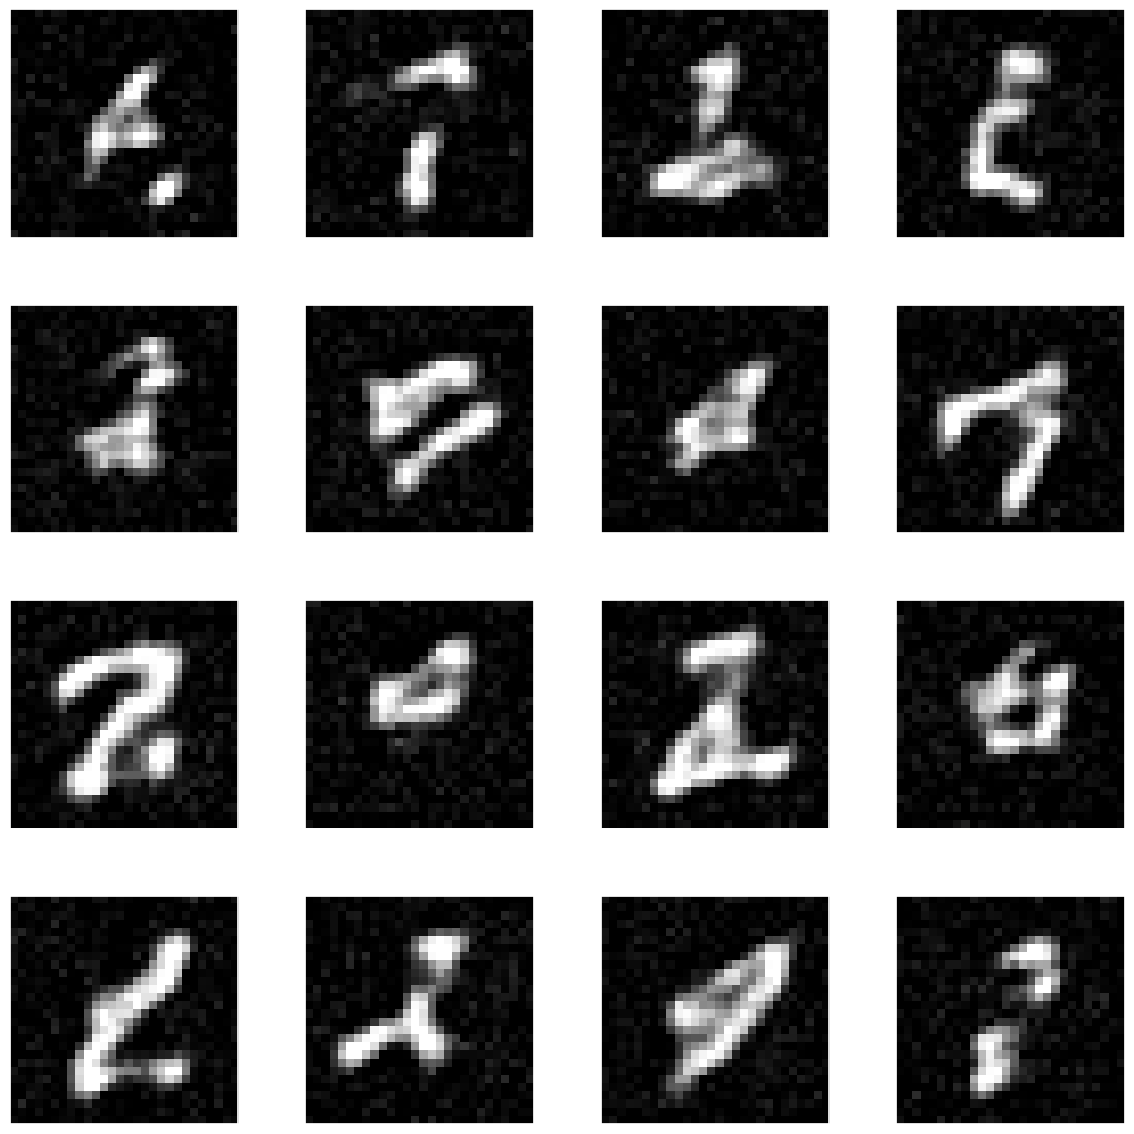

In [1]:
import matplotlib.pyplot as plt
import optax
from jax import random
import jax.numpy as jnp
from tqdm import tqdm

import utils
from unet import Unet

def sample(state, n, ts, key):
  # random white noise X_T
  key, subkey = random.split(key)
  x_t = random.normal(subkey, shape=(n, 28, 28, 1))

  step=0

  for k in tqdm(range(len(ts))[::-1]):
    key, subkey = random.split(key)
    z = random.normal(subkey, shape=x_t.shape)

    t = ts[k]
    dt = jnp.where(k > 0, t - ts[k-1], 0.)

    f_theta = state.apply_fn(state.params, x_t, t * jnp.ones((n,)))

    # equation (40)
    s_theta = jnp.where(k > 0, x_t/(1-jnp.exp(-t))  - jnp.exp(-t/2)/(1-jnp.exp(-t)) * f_theta,  0.)

    # equation (24)
    x_t_bar = x_t - dt * s_theta
    x_t = jnp.exp(dt/2) * x_t_bar + jnp.sqrt(1-jnp.exp(-dt)) * z

    x_t = jnp.clip(x_t, -1., 1.) # should we clip ...
    #x_t = normalize_to_neg_one_to_one(x_t) # or scale?

    step=step+1

  return x_t

key = random.PRNGKey(SEED)

# use the best params
file_path, epoch, step, loss = utils.find_latest_pytree(f'{PROJECT_DIR}/cem_params_*.npy')
cem_state = utils.create_training_state(params_file=f'{PROJECT_DIR}/cem_params_{epoch}_{step}_{loss}.npy')
print(f'using parameters from epoch {epoch} with loss {loss}')

ts = utils.exponential_time_schedule(T, K)

# generate x_0 from noise
key, subkey = random.split(key)
x_0_tilde = sample(cem_state, 16, ts, subkey)

# plot the data
utils.show_img_grid(utils.unnormalize_image(x_0_tilde))

## References



-   [http://xrayphysics.com/ctsim.html](http://xrayphysics.com/ctsim.html)
-   [https://scikit-image.org/docs/stable/auto_examples/transform/plot_radon_transform.html](https://scikit-image.org/docs/stable/auto_examples/transform/plot_radon_transform.html)
-   [https://github.com/dzwiedzn7/filtered-back-projection/blob/master/tompy.py](https://github.com/dzwiedzn7/filtered-back-projection/blob/master/tompy.py)
-   [https://github.com/Feanor007/Thin2Thick](https://github.com/Feanor007/Thin2Thick)
-   [https://pypi.org/project/algotom/](https://pypi.org/project/algotom/)
-   [https://github.com/cabouman/OpenMBIR-Index/blob/master/README.md](https://github.com/cabouman/OpenMBIR-Index/blob/master/README.md)
-   [https://humanhealth.iaea.org/HHW/MedicalPhysics/NuclearMedicine/ImageAnalysis/3Dimagereconstruction/index.html](https://humanhealth.iaea.org/HHW/MedicalPhysics/NuclearMedicine/ImageAnalysis/3Dimagereconstruction/index.html)
-   [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6899669/>](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6899669/>)Pyro-NN
-   [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4181643/>](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4181643/>)TomoPy
-   [http://www.sci.utah.edu/~shireen/pdfs/tutorials/Elhabian_CT09.pdf](http://www.sci.utah.edu/~shireen/pdfs/tutorials/Elhabian_CT09.pdf)
-   Astra [https://github.com/astra-toolbox/astra-toolbox](https://github.com/astra-toolbox/astra-toolbox)
-   ODL [https://github.com/odlgroup/odl/tree/master/examples/tomo](https://github.com/odlgroup/odl/tree/master/examples/tomo)

